# Exactly the same as HW 1, but use algorithm 2.  You are encouraged to experiment with step size versions.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.interpolate import interp1d

df = pd.read_csv('russell_prices.txt', sep=' ', header=None, skiprows=2)

# Dropping first two rows
df=df.drop(504,1) 
data=df.to_numpy()

#Calculating returns  
sample_returns=(data[:,1:504]-data[:,0:503])/data[:,0:503]


#Calculating Average of means and printing the maximum average value of returns 
sample_mean_returns=np.mean(sample_returns,axis=1)
print(sample_mean_returns.max)

#Calculating Covariance Matrix of returns
sample_cov_matrix=np.cov(sample_returns)

# get feasible solution
def get_feasible_x(l,u):
   
    
# Assigning lower limit to all values of x    
    x = np.array(l)

# Checking if summation of x is close to 1
    if abs(x.sum() - 1) < 0.01:
        return x
    
# Checking if summation of x is exceeding 1, problem would be infeasible (no solution exist)   
    elif x.sum() > 1:
        raise Exception('The problem is infeasible! Sum of all lower bounds larger than 1')
    else:
        i = 0
         
        while x.sum() < 1 and i <= 946:
            if 1-x.sum()<=(u[i] - l[i]):
                x[i]=x[i]+1-x.sum()
                return x
            else:
                x[i] = u[i]
                i += 1
# If all of the above conditions does not staisfy, it means summation of x exceeds 1 and x = u(upper limit), feasible solution does not exist
    raise Exception('The problem is infeasible! Sum of all upper bounds smaller than 1')


# get y

# Finding the gradient of the function f

def find_gradient(x,mean_return,cov_matrix,lamda):
    g=np.zeros(947)
    for i in range(len(x)-1):
        g[i]=lamda*(2*cov_matrix[i,i]*x[i]+2*sum(cov_matrix[i,i+1:]*x[i+1:]))-mean_return[i]
    g[len(x)-1]=lamda*(2*cov_matrix[i,i] * x[i])-mean_return[i]
    return g

def sort_grads(g):
    arr = np.asarray(g)
    out=np.argsort(arr)
    grads_high_to_low=np.flip(out)
    return grads_high_to_low



# Solving the linear problem
def auxiliary_LP(index,l,u,x,g):
    y_prime=np.zeros(len(index))
    for m in range(len(index)):
        y=np.zeros(len(index))
        y[index[:m]]=l[index[:m]]-x[index[:m]]
        y[index[m+1:len(index)]]=u[index[m+1:len(index)]]-x[index[m+1:len(index)]]
        a=0 - sum(y[index[:m]]) - sum(y[index[m+1:]])
        if l[index[m]]-x[index[m]]<=a and a<=u[index[m]]-x[index[m]]: #feasible y
            y[index[m]]=a
            if np.dot(g,y)<np.dot(g,y_prime):
                y_prime=y.copy()
    return y_prime

def get_y(x,mean_return,cov_matrix,l,u,lamda):
    g=find_gradient(x,mean_return,cov_matrix,lamda)
    index=sort_grads(g)
    return auxiliary_LP(index,l,u,x,g)

def obj_val(x,lamda):
    obj = lamda * np.dot(np.dot(np.transpose(x), sample_cov_matrix),x)  - np.dot(np.transpose(x),sample_mean_returns)
    return obj

def derivative(x,s,y,lamda,h=0.0001):
    drvt = (obj_val(x+(s+h)*y,lamda)-obj_val(x+s*y,lamda))/h
    return drvt

def s_star(x,y,lamda,h=0.0001):
    sl,su,sm=0,1,1/2
    # search for zero point
    while abs(derivative(x,sm,y,lamda))>0.001:
        upper,lower = derivative(x,su,y,lamda,h=0.0001),derivative(x,sl,y,lamda,h=0.0001)
        # Monotonous of s, return the s mins obj
        if lower*upper >0: return su if obj_val(x+su*y,lamda)<obj_val(x+sl*y,lamda) else sl
        #binary search
        mid = derivative(x,sm,y,lamda,h=0.0001)
        if mid * lower <0: 
            su = sm
        else: 
            sl = sm
        sm = (su+sl)/2
    return sm

def optimal_x(x,y,s,lamda,h,stop_dif=0.001):
    x_1=x+s*y
    if np.all(y==0):
        return x
    elif obj_val(x,lamda)<obj_val(x_1,lamda):
        print('the objective value increases after the movement')
        return x
    elif obj_val(x,lamda)-obj_val(x_1,lamda)<stop_dif:
        return x_1
    else:
        x=x_1
        y=get_y(x,sample_mean_returns,sample_cov_matrix,l,u,lamda)
        s=s_star(x,y,lamda,h)
        return optimal_x(x,y,s,lamda,h,stop_dif)
    
def mean_variance_opt(lamda,l,u,sample_cov_matrix,sample_mean_returns,h,stop_dif):  
    x=get_feasible_x(l,u)
    y=get_y(x,sample_mean_returns,sample_cov_matrix,l,u,lamda)
    s=s_star(x,y,lamda,h)
    x=optimal_x(x,y,s,lamda,h,stop_dif)
    return x

<built-in method max of numpy.ndarray object at 0x00000208E0ED4E40>


when lambda=0, total risk of my optimal basket is: 0.0186367839338458
Total number of asset in my basket is: 1


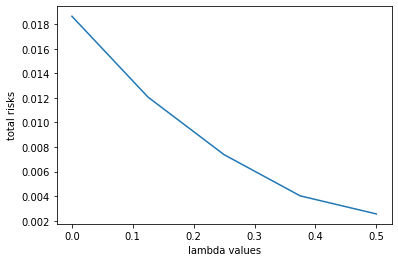

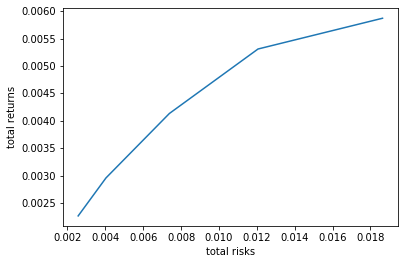

min variance I have is: 0.002563907232526064
medium risk is: 0.010600345583185932
The lambda estimate for s2_mid is: 0.16403060370362343


In [20]:
l = np.full(947, 0)
u = np.full(947, 1)
x=mean_variance_opt(0,l,u,sample_cov_matrix,sample_mean_returns,0.0001,0.001)


# Finding total risks
def total_risk(x,cov_matrix):
    return np.dot(np.dot(x,cov_matrix),x.T)
def total_return(x, sample_mean_returns):
    return np.dot(x, sample_mean_returns)
#Question 3 

s2_0=total_risk(x,sample_cov_matrix)
print('when lambda=0, total risk of my optimal basket is:', s2_0)
print('Total number of asset in my basket is:',np.count_nonzero(x))

# Question 4

# Creating list of lamba ranging from 0 to 0.5 with an increment step of 0.125
lam = [i for i in np.linspace(0, 0.5, 5)]
risks = []
returns=[]
for lamda in lam:
    risks.append(total_risk(mean_variance_opt(lamda,l,u,sample_cov_matrix,sample_mean_returns,0.0001,0.001), sample_cov_matrix))
    returns.append(total_return(mean_variance_opt(lamda,l,u,sample_cov_matrix,sample_mean_returns,0.0001,0.001),sample_mean_returns))

# Plotting the graph of risk vs lambda
plt.plot(lam, risks)
plt.ylabel('total risks')
plt.xlabel('lambda values')
plt.savefig('HW1 Q4 Plot of variance.png')
plt.show() 

#plot risk vs return 
plt.plot(risks, returns)
plt.ylabel('total returns')
plt.xlabel('total risks')
plt.show() 

# Calculating minimum risk amongst all values of given risks
min_risk = min(risks)
print('min variance I have is:', min_risk)

#question5
# Calculating mid risk
s2_mid = (s2_0 + min_risk) / 2
print('medium risk is:', s2_mid)

# Interpolating the value of lambda at mid risk by calculating function f
f = interp1d(risks, lam)
print('The lambda estimate for s2_mid is:', f(s2_mid))
